In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Configurations 

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# Cargar y preparar la dataset

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch

file_path = "../db/db3.csv"
data = pd.read_csv(file_path)

# etiquetas (M = 1, B = 0)
data.iloc[:, 1] = data.iloc[:, 1].map({'M': 1, 'B': 0})

# Separar en características 
X = data.iloc[:, 2:].values 
y = data.iloc[:, 1].values

# Normalizar los datos
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Configurar el dispositivo para PyTorch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Convertir a tensores de PyTorch
X_train = torch.from_numpy(X_train).float().to(device)
y_train = torch.from_numpy(y_train).long().to(device)  
X_test = torch.from_numpy(X_test).float().to(device)
y_test = torch.from_numpy(y_test).long().to(device) 


In [4]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

torch.Size([340, 30])
torch.Size([340])
torch.Size([228, 30])
torch.Size([228])


In [5]:
X_train

tensor([[-0.1905, -0.2346, -0.2190,  ..., -0.2334, -0.3338, -0.2597],
        [ 0.7185,  0.4842,  0.7453,  ..., -0.2710, -0.3234, -0.2442],
        [-0.5313,  0.7316, -0.5660,  ..., -0.2436, -0.3601, -0.2513],
        ...,
        [-0.8040, -1.4622, -0.8113,  ...,  5.3794, -0.3332, -0.2523],
        [-0.3552,  0.0548, -0.3810,  ..., -0.2433, -0.3267, -0.2538],
        [-1.2057,  0.0221, -1.1525,  ..., -0.2215, -0.3344,  4.1573]])

In [6]:
y_train

tensor([0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
        1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
        0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
        0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1,
        0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,

# MLP

In [7]:
# Parámetros de la red neuronal MLP
params = {
    "input_size": X_train.shape[1],     #  Número de características (elemento de entrada)
    "hidden_layers": [20, 15, 10, 8, 5],  #  red con 5 capas ocultas
    "output_size": 2,                   #  Número de neuronas en la capa de salida para CrossEntropyLoss
    "activation_function": nn.ReLU()    #  Tipo de función de activación para las capas ocultas
}

In [8]:
# Red neuronal MLP
class MLP(torch.nn.Module):
    def __init__(self, params):
        super(MLP, self).__init__()
        layers = [nn.Linear(params["input_size"], params["hidden_layers"][0]), params["activation_function"]]
        for i in range(len(params["hidden_layers"]) - 1):
            layers.append(nn.Linear(params["hidden_layers"][i], params["hidden_layers"][i+1]))
            layers.append(params["activation_function"])
        layers.append(nn.Linear(params["hidden_layers"][-1], params["output_size"]))
        # No aplicar Sigmoid en la capa de salida
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

model = MLP(params).to(device)
loss_function = nn.CrossEntropyLoss()  # CrossEntropyLoss para clasificación
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
# Convertir etiquetas a LongTensor
y_train = y_train.long().to(device)
y_test = y_test.long().to(device)

# Training

In [10]:
# Función de entrenamiento 
def train(model, loss_function, optimizer, epochs, X_train, y_train):
    model.train()
    loss_history = []  # Lista para guardar el historial de pérdida
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = loss_function(y_pred, y_train)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())  # Guardar la pérdida de cada época
        
        if epoch % 100 == 0:
            print(f'Epoch {epoch} Loss: {loss.item()}')
    
    return loss_history  # Retornar el historial de pérdida


# Train model

In [11]:
#train(model, loss_function, optimizer, 1000, X_train, y_train)
loss_history = train(model, loss_function, optimizer, 1500, X_train, y_train)

Epoch 0 Loss: 0.6519548296928406
Epoch 100 Loss: 0.24629127979278564
Epoch 200 Loss: 0.017673315480351448
Epoch 300 Loss: 0.003288155421614647
Epoch 400 Loss: 0.0007860364275984466
Epoch 500 Loss: 0.0003402315196581185
Epoch 600 Loss: 0.00018801612895913422
Epoch 700 Loss: 0.00012125739158364013
Epoch 800 Loss: 8.560725109418854e-05
Epoch 900 Loss: 6.37995544821024e-05
Epoch 1000 Loss: 4.933377931592986e-05
Epoch 1100 Loss: 3.9186288631753996e-05
Epoch 1200 Loss: 3.18869024340529e-05
Epoch 1300 Loss: 2.6399444323033094e-05
Epoch 1400 Loss: 2.2166825146996416e-05


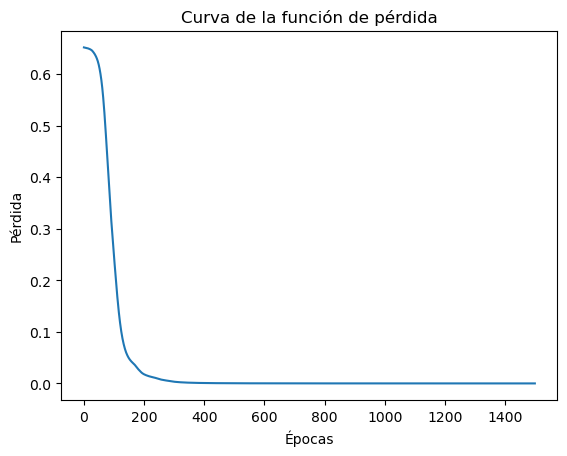

In [12]:
plt.plot(loss_history)
plt.title('Curva de la función de pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.show()

# Accuracy

In [13]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    max_values, predicted_classes = torch.max(y_pred, 1)  # Obtener la clase con la máxima puntuación
    correct_predictions = predicted_classes.eq(y_test).sum().item()
    accuracy = correct_predictions / y_test.shape[0]
    print(f'max_values: {max_values} Accuracy: {accuracy}')


max_values: tensor([20.0967, 12.4248,  7.9486, 12.1982, 10.1677, 28.0381,  6.7433, 14.4829,
        11.4561, 10.1596,  8.2237, 14.6331, 16.6579,  5.1931,  1.3590, 11.6873,
         4.7866,  8.6036,  6.5340,  9.6729, 15.7944, 11.8105, 18.6413, 11.5933,
        10.0620,  3.9895, 19.6989, 16.9614, 13.6670,  7.3870, 11.3870,  7.3690,
         5.0652,  7.9006,  4.7313, 42.6775,  6.3680,  9.5658,  1.2055,  8.3181,
        11.0489, 10.1322, 16.3580, 10.8841,  6.0267, 13.7080,  9.9362,  1.2238,
        13.6712, 12.9176, 17.4704,  5.5626, 11.9973, 10.5327,  6.2441,  6.2721,
         5.6507,  5.3015, 14.5820, 13.7190,  7.8932, 20.6380, 13.3136, 11.5075,
        11.1313,  6.6072, 12.9561, 21.8946, 18.1934, 20.8541, 13.5803, 26.8983,
        10.3505, 14.3998, 18.9413, 11.6663,  9.9760, 11.0845, 14.8781, 10.4749,
         8.8279,  4.4337,  8.5330,  3.0089, 12.6615, 12.7822,  9.4391,  5.6081,
         9.3562, 17.2242, 11.9345, 17.7573,  3.0714, 12.2823,  4.1287, 16.0190,
        15.0529,  8.6225, 19

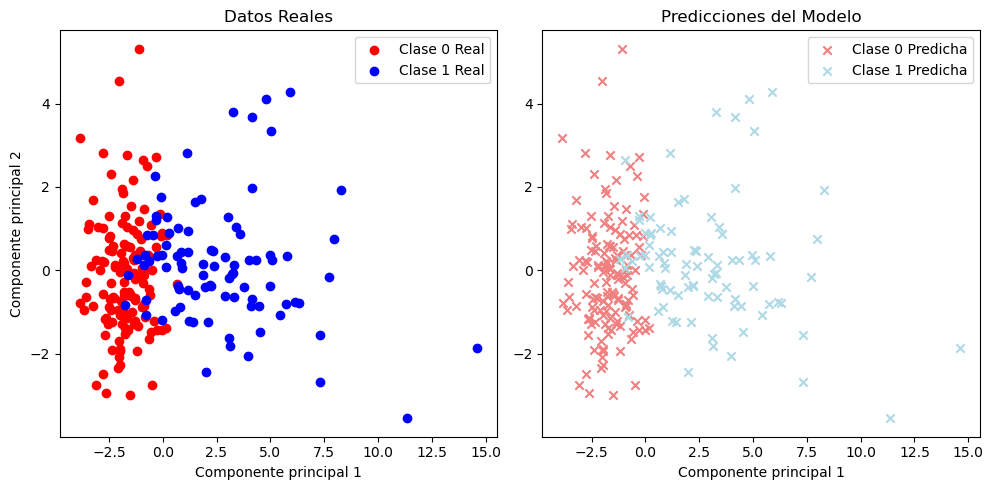

In [14]:
from sklearn.decomposition import PCA

# Reducir la dimensionalidad de los datos de prueba 
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test.cpu())

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_test_pca[y_test.cpu() == 0][:, 0], X_test_pca[y_test.cpu() == 0][:, 1], color='red', label='Clase 0 Real')
plt.scatter(X_test_pca[y_test.cpu() == 1][:, 0], X_test_pca[y_test.cpu() == 1][:, 1], color='blue', label='Clase 1 Real')
plt.title('Datos Reales')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.legend()

# Graficar las predicciones del modelo
plt.subplot(1, 2, 2)
plt.scatter(X_test_pca[predicted_classes == 0][:, 0], X_test_pca[predicted_classes == 0][:, 1], color='lightcoral', marker='x', label='Clase 0 Predicha')
plt.scatter(X_test_pca[predicted_classes == 1][:, 0], X_test_pca[predicted_classes == 1][:, 1], color='lightblue', marker='x', label='Clase 1 Predicha')
plt.title('Predicciones del Modelo')
plt.xlabel('Componente principal 1')
plt.legend()

plt.tight_layout()
plt.show()
